In [2]:
from fastai.vision.all import *
from pathlib import Path
import torch, numpy as np, pandas as pd

# Traffic Sign Recognition

We'll build a traffic sign recognizer/classifier for Belgian traffic signs.  The dataset we'll use is downloaded from [people.ee.ethz.ch](https://people.ee.ethz.ch/~timofter/traffic_signs/). See publication:

@inproceedings{Timofte-BMVC-2011,
author = {Radu Timofte and Luc Van Gool},
title  = {Sparse representation based projections},
booktitle = {British Machine Vision Conference},
year   = {2011},
}

@article{Timofte-MVA-2011,
  author = {Radu Timofte and Karel Zimmermann and Luc {Van Gool}},
  title = {Multi-view Traffic Sign Detection, Recognition, and 3D Localisation},
  journal = {Machine Vision and Applications},
  year = {2011}, 
  doi  = {10.1007/s00138-011-0391-3},
}


In [3]:
# Fetch data from people.ee.ethz.ch
from zipfile import ZipFile
data_path = Path('./traffic-sign')
training_path = untar_data(url='https://people.ee.ethz.ch/~timofter/BelgiumTSC/BelgiumTSC_Training.zip', base=data_path.absolute(), data=data_path.absolute())
testing_path = untar_data(url='http://www.vision.ee.ethz.ch/~timofter/BelgiumTSC/BelgiumTSC_Testing.zip', base=data_path.absolute(), data=data_path.absolute())

## Data Discovery

Let's have a look at one single image from the dataset first, so we know what we're dealing with.

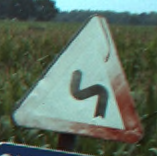

In [4]:
data_path = Path('./traffic-sign')
training_path = Path(data_path/'BelgiumTSC_Training')
testing_path = Path(data_path/'BelgiumTSC_Testing')
img = PILImage.create(training_path/'00006/00147_00000.ppm')
img.to_thumb(400)

In [5]:
training_path.absolute()

Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training')

## Build a quick first model

We'll use FastAI to build a quick first model and see how far we get with that:

In [6]:
fnames = get_image_files(training_path) # gives us something like: [Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00221_00000.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00327_00001.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00326_00001.ppm')]
def label_func(x): return x.parent.name
dls = ImageDataLoaders.from_path_func(training_path.absolute(), fnames, label_func, valid_ptc=0.2, seed=42, item_tfms=Resize(224))
dls.valid_ds.items[:3]

[Path('traffic-sign/BelgiumTSC_Training/00022/00293_00001.ppm'),
 Path('traffic-sign/BelgiumTSC_Training/00032/01824_00000.ppm'),
 Path('traffic-sign/BelgiumTSC_Training/00034/01214_00002.ppm')]

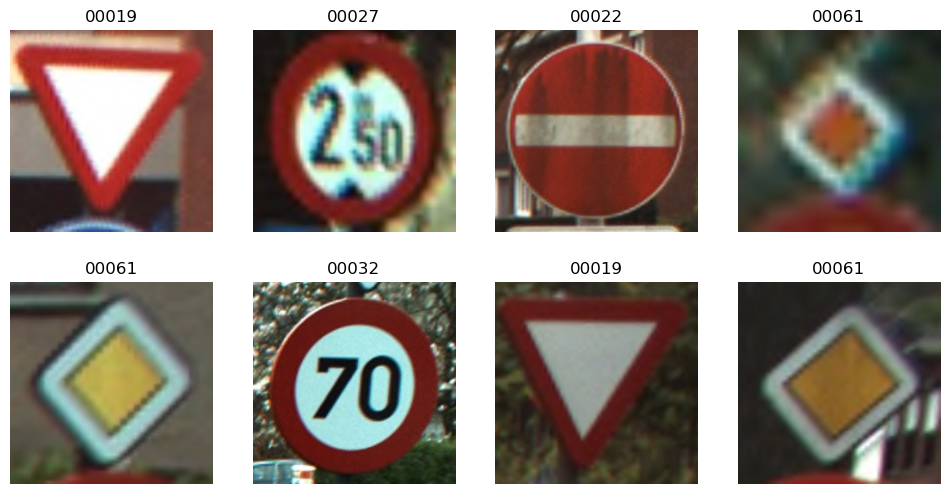

In [7]:
dls.show_batch(nrows=2, ncols=4)

In [8]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/home/xstof/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/xstof/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.786644,0.670970,0.169399,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.524717,0.168807,0.044809,00:17
1,0.239047,0.112132,0.026230,00:16


Let's experiment with using a different learning rate; inspired by the learning rate finder:

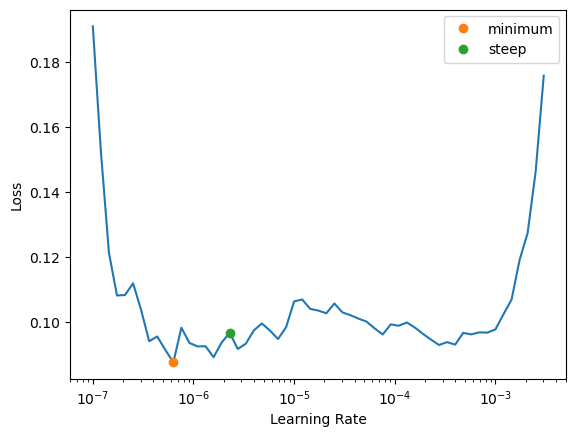

In [9]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [10]:
#learn = vision_learner(dls, resnet50, metrics=error_rate)
learn = vision_learner(dls, resnet34, metrics=error_rate)
#learn.fine_tune(9, base_lr=1e-4, freeze_epochs=3)
learn.fine_tune(60, base_lr=1e-4)

/home/xstof/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/xstof/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,5.440722,3.599473,0.825137,00:12


epoch,train_loss,valid_loss,error_rate,time
0,4.444081,3.250834,0.738798,00:16
1,4.187634,2.910907,0.674317,00:16
2,3.871852,2.583495,0.591257,00:16
3,3.493589,2.285804,0.501639,00:16
4,3.156797,1.998033,0.448087,00:16
5,2.803589,1.746028,0.393443,00:16
6,2.434762,1.500307,0.334426,00:16
7,2.125607,1.292414,0.285246,00:16
8,1.876534,1.108304,0.245902,00:16
9,1.608502,0.950422,0.216393,00:16


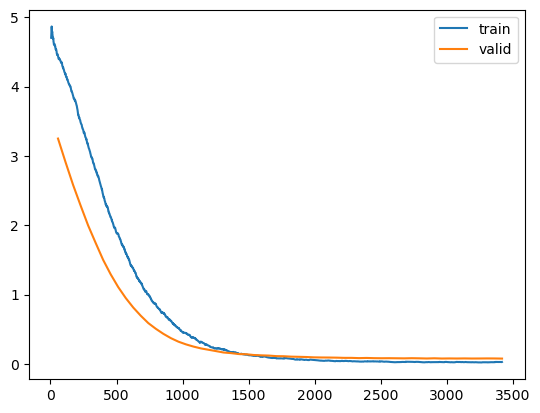

In [11]:
learn.recorder.plot_loss()

What we learn here is that with a slow learning rate and 60 epochs, we're getting down to an error rate of 0.0185 or approximately 2%.  Let's have a look at where those errors are in our data set by looking at a couple of examples.

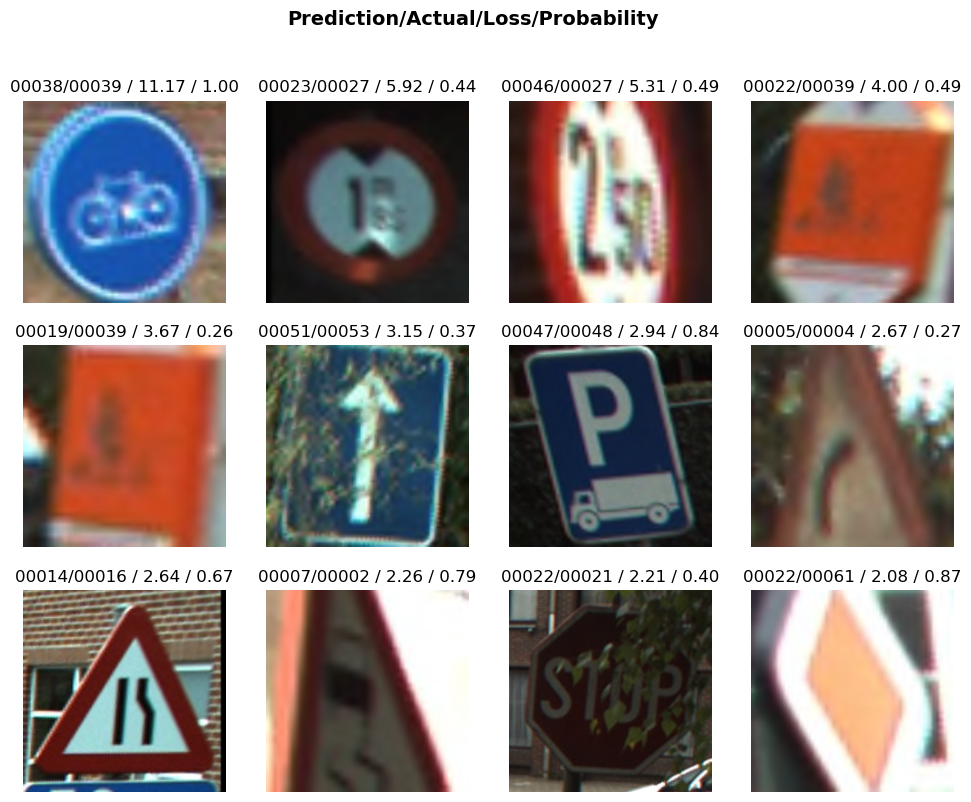

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
# interp.most_confused()
interp.plot_top_losses(12)

In [13]:
learn.lr

0.001

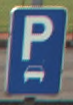

In [14]:
img = PILImage.create(training_path/'00047/00010_00000.ppm')
img.to_thumb(400)

## Data Augmentation

We'll bring more variation in our dataset by augmenting our data now: resizing, skewing etc..

In [26]:
fnames = get_image_files(training_path) # gives us something like: [Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00221_00000.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00327_00001.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00326_00001.ppm')]
def label_func(x): return x.parent.name
print(f'taking training images from path: {training_path.absolute()}')
# dls = ImageDataLoaders.from_path_func(training_path.absolute(), fnames, label_func, valid_ptc=0.2, seed=42, 
#                                     item_tfms=RandomResizedCropGPU(224, min_scale=.5),
#                                     batch_tfms=aug_transforms())
dls = ImageDataLoaders.from_path_func(training_path.absolute(), fnames, label_func, valid_ptc=0.2, seed=42, 
                                      item_tfms=Resize(224),
                                      batch_tfms=aug_transforms())

taking training images from path: /home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training


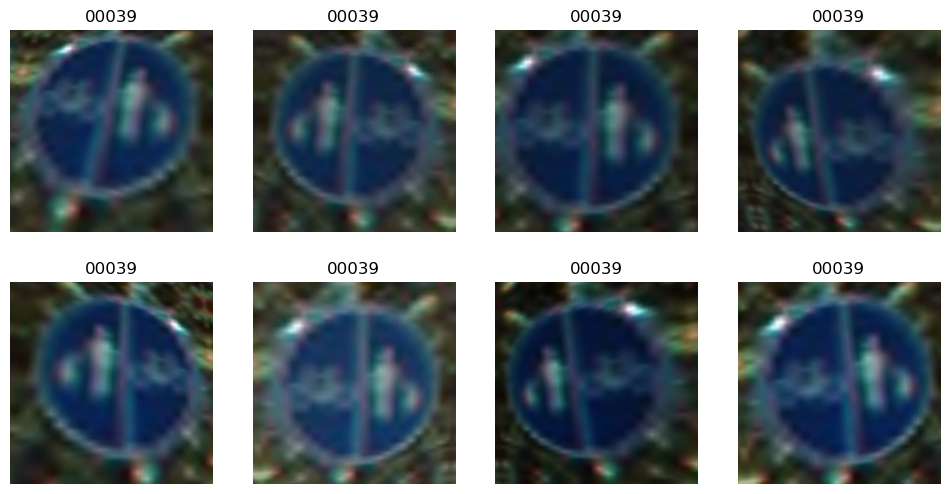

In [31]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now let's train another model using these augmented versions of our images:

In [36]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

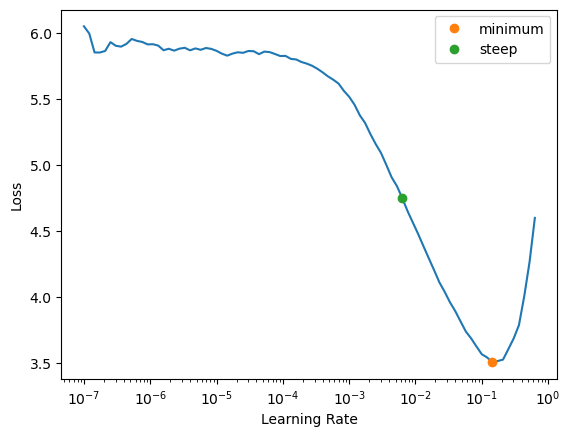

In [37]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [38]:
learn.fine_tune(60, base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.495308,1.074785,0.274317,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.359122,0.674494,0.156284,00:17
1,1.041120,0.482047,0.114754,00:17
2,0.781026,0.364297,0.088525,00:17
3,0.597568,0.266518,0.064481,00:17
4,0.464273,0.210976,0.050273,00:18
5,0.351942,0.163712,0.040437,00:18
6,0.259051,0.129586,0.033880,00:18
7,0.189882,0.109167,0.030601,00:18
8,0.142590,0.087978,0.021858,00:18
9,0.109195,0.084499,0.020765,00:18


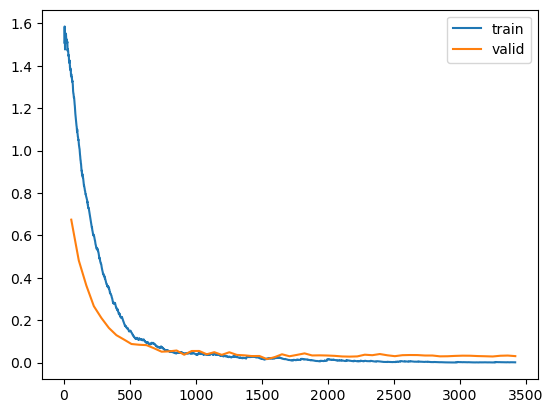

In [39]:
learn.recorder.plot_loss()

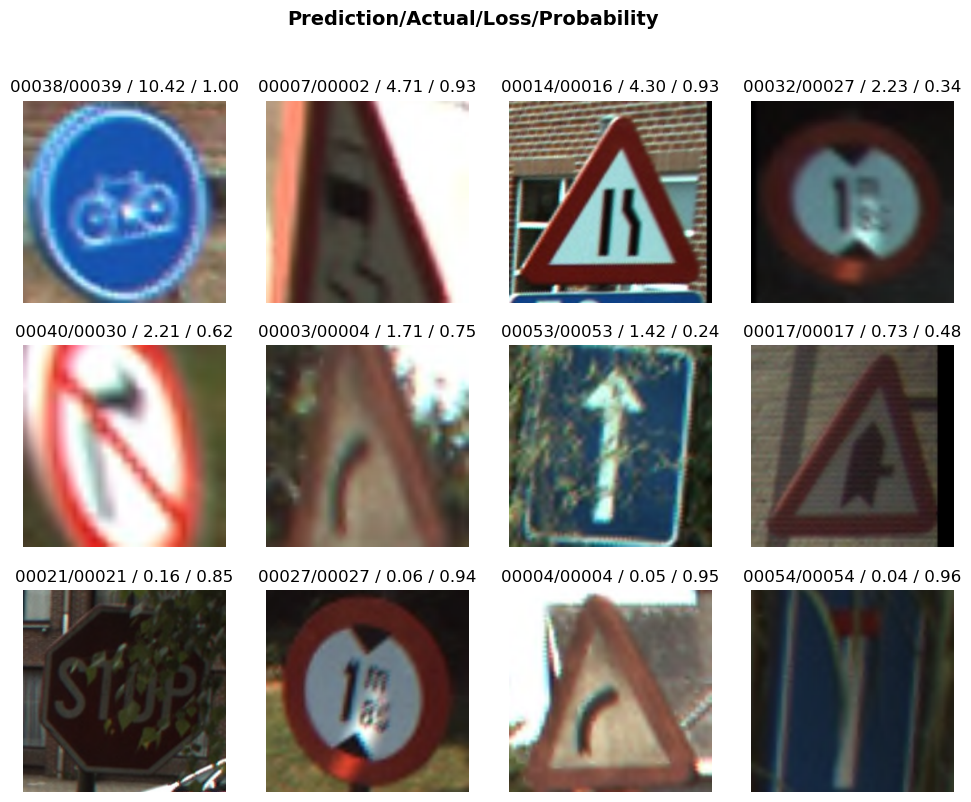

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(12)

Something tells us that there might still be images wrongly classified in our training data.  We can explore this using the `ImageClassifierCleaner` widget.  When we do so, it turns out that indeed there's images that are wrongly classified in our dataset.  Let's clean those up.

In [47]:
import ipywidgets
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [49]:
deleted = cleaner.delete()
for d in deleted: print(f'deleted: {d}')
for idx,cat in cleaner.change(): print(f'index: {idx} in cat: {cat}')

deleted: 8
index: 0 in cat: 00038
index: 1 in cat: 00038
index: 4 in cat: 00038
index: 7 in cat: 00038


In [50]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [56]:
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
for idx,cat in cleaner.change(): print(f'move {dls.train.items[idx]} to ')

move traffic-sign/BelgiumTSC_Training/00039/00953_00002.ppm to 
move traffic-sign/BelgiumTSC_Training/00037/01875_00001.ppm to 
move traffic-sign/BelgiumTSC_Training/00019/00146_00002.ppm to 
move traffic-sign/BelgiumTSC_Training/00027/01490_00002.ppm to 
